In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
image_dir = "C:\\Users\\USER\\Documents\\4-2  Thesis\\train_validation(1)"  # Directory containing images
csv_path = "C:\\Users\\USER\\Documents\\4-2  Thesis\\Dataset\\train_validate_set.csv"  # Path to CSV file

In [3]:
# Step 3: Load CSV containing image paths and labels
img_height, img_width = 299, 299
batch_size = 32
epochs = 30

In [4]:
# Load the CSV file
data_df = pd.read_csv(csv_path)

In [5]:
# Add the full file paths to the dataframe
data_df['file_path'] = data_df['image_id'].apply(lambda x: os.path.join(image_dir, x+".jpg"))
data_df['label'] = data_df['label'].astype(str)

In [6]:

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # Split 20% for validation
)


In [7]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_df,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=data_df,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)


Found 6523 validated image filenames belonging to 4 classes.
Found 1630 validated image filenames belonging to 4 classes.


In [8]:
num_classes = len(train_generator.class_indices)

In [9]:
# Load the InceptionV3 model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

In [10]:
# Freeze the base model layers
base_model.trainable = False

In [11]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
output_layer = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output_layer)


In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [15]:
# Add callbacks for dynamic learning rate adjustment and early stopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
]

In [16]:
# Train the model
history=model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/30
204/204 [==============================] - 24s 90ms/step - loss: 0.6658 - accuracy: 0.7596 - val_loss: 0.5706 - val_accuracy: 0.7798 - lr: 0.0010
Epoch 2/30
204/204 [==============================] - 17s 84ms/step - loss: 0.4960 - accuracy: 0.8052 - val_loss: 0.5381 - val_accuracy: 0.7908 - lr: 0.0010
Epoch 3/30
204/204 [==============================] - 20s 99ms/step - loss: 0.4572 - accuracy: 0.8191 - val_loss: 0.5302 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 4/30
204/204 [==============================] - 17s 84ms/step - loss: 0.4406 - accuracy: 0.8249 - val_loss: 0.5014 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 5/30
204/204 [==============================] - 19s 93ms/step - loss: 0.4016 - accuracy: 0.8415 - val_loss: 0.5045 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 6/30
204/204 [==============================] - 17s 83ms/step - loss: 0.3802 - accuracy: 0.8531 - val_loss: 0.5177 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 7/30

Epoch 7: ReduceLROnPlateau reducing learning r

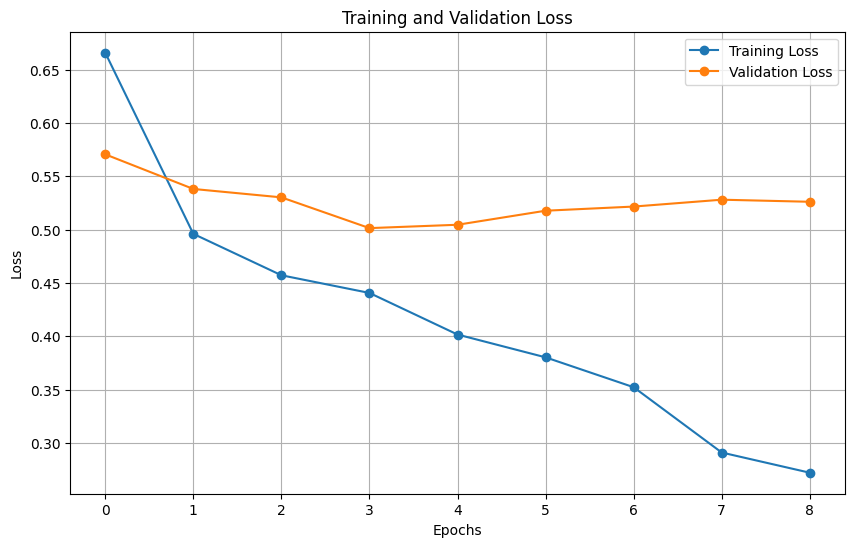

In [17]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)

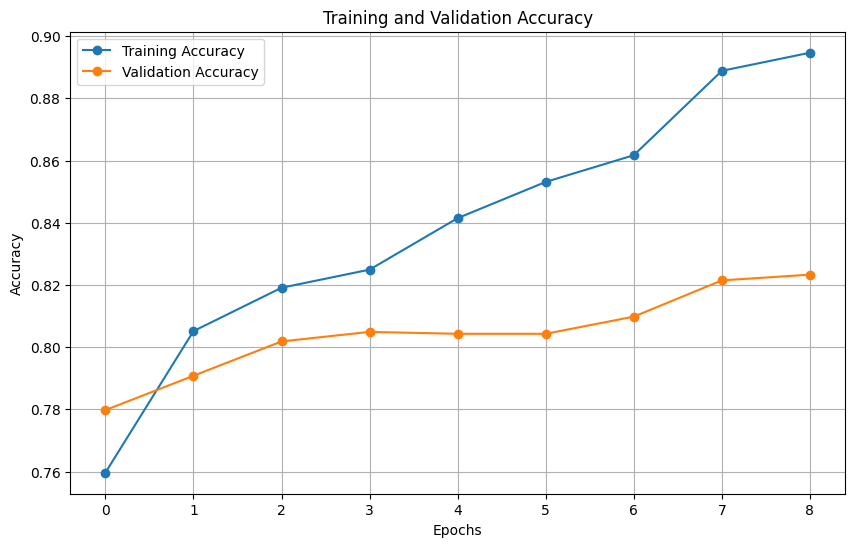

In [18]:
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

plot_accuracy(history)

In [ ]:
# Add new top layers to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(len(np.unique(labels)), activation='softmax')(x)  # Output layer based on number of classes

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
# Step 11: Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Step 12: Set up callbacks (EarlyStopping and ModelCheckpoint)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('inceptionv3_best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


In [ ]:
# # Fine-tune the model
# for layer in base_model.layers:
#     layer.trainable = 

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)

In [ ]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

plot_accuracy(history)


In [9]:
# Step 15: Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

NameError: name 'model' is not defined

In [26]:
test_image_path = "E:\\Mehedy\\test_image"
test_dataset_path = "E:\\Mehedy\\Dataset\\test_set.csv"

In [27]:
test_df = pd.read_csv(test_dataset_path)

In [28]:
test_df.head()

,image_id,MEL,NV,BKL,VASC,label
0,ISIC_0024310,1,0,0,0,0
1,ISIC_0024311,0,1,0,0,1
2,ISIC_0024315,1,0,0,0,0
3,ISIC_0024368,0,1,0,0,1
4,ISIC_0024378,0,1,0,0,1


In [29]:
test_image_files = test_df['image_id'].values
test_labels = test_df['label'].values

In [30]:
X_test = load_and_preprocess_images(test_image_files, test_image_path)

In [31]:
test_labels_encoded = label_encoder.transform(test_labels)

In [32]:
y_test_one_hot = tf.keras.utils.to_categorical(test_labels_encoded)

In [33]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

29/29 [==============================] - 1s 36ms/step - loss: 0.4841 - accuracy: 0.8289
Test Loss: 0.4840814471244812
Test Accuracy: 0.8289183378219604
